# Grammatical Gender and Semantic Gender on FastText embeddings

In this notebook, we explore the works in the papers 
- [Examining Gender Bias in Languages with Grammatical Gender](https://aclanthology.org/D19-1531.pdf)
- [Measuring Gender Bias in Word Embeddings of Gendered
Languages Requires Disentangling Grammatical Gender Signals](https://arxiv.org/pdf/2206.01691.pdf)

on the FastText embeddings.

In [1]:
# loading the embeddings
import io
import numpy as np


def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for i, line in enumerate(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:]).astype(float)
    return data

data = load_vectors("../../models_prev/fasttext/cc.fr.300.vec")

### Extracting semantic gender direction 

To extract the semnatic gender direction, we use a set of pairs of gender definition words. However, it is imortant to select the appropriate set that is less likely to encode gender bias (i.e. avoid words like `'présidente'- 'président'`, `'infirmière'- 'infirmier'`).

In the sequel we select the following pairs of words: `['madame', 'monsieur'], ["femme", "homme"], ['grand-mère', 'grand-père'], ["mère", "père"], ['fille', 'garçon'], ['sœur', 'frère']`, that have been empirically proven to separate gender pairs well.

In [3]:
import numpy as np
from sklearn.decomposition import PCA

# gender definition pairs
gender_def = [['madame', 'monsieur'], ["femme", "homme"], ['grand-mère', 'grand-père'], ["mère", "père"], ['fille', 'garçon'], ['sœur', 'frère']]
# female - male vectors
diff_gender_vect = [data[male] - data[female] for female, male in gender_def]

# extract semantic gender direction
X = np.array(diff_gender_vect)
pca = PCA(n_components=1)
pca.fit(X)
d_pca = pca.components_ 

# plot the projections of the gender_def pairs on the d_pca direction
n_g_def = len(gender_def) # nb of pairs
y_ = np.linspace(1, 20, n_g_def)   # y-axis for the plot (used to separate gender_def pairs)
x_ = np.array([[d_pca.dot(data[female])[0], d_pca.dot(data[male])[0]] for female, male in gender_def])


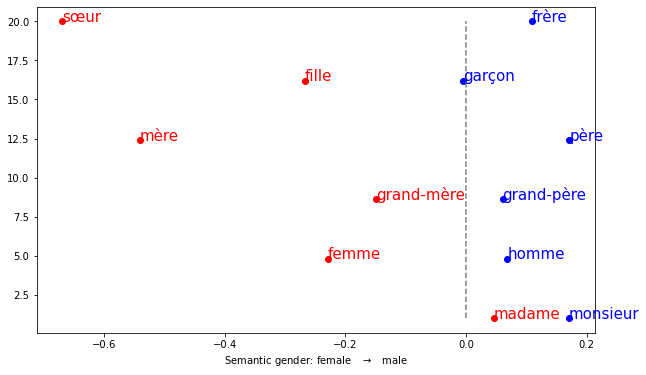

In [4]:
# plot of words on the semantic gender axis
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.scatter(x_[:, 0], y_, color='red')  # female component
plt.scatter(x_[:, 1], y_, color='blue') # male component

# annotation of the points on the scatter plot
for label, x, y in zip(np.array(gender_def)[:, 0], x_[:, 0], y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')
  
for label, x, y in zip(np.array(gender_def)[:, 1], x_[:, 1], y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')

plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

plt.xlabel(r"Semantic gender: female   $\rightarrow$   male")
plt.show()


The male and female component of each pair lie on the same side of the semantic gender direction (left for female and right for males).

To further confirm this, we perform the same process on pairs of occupation words, as follows.

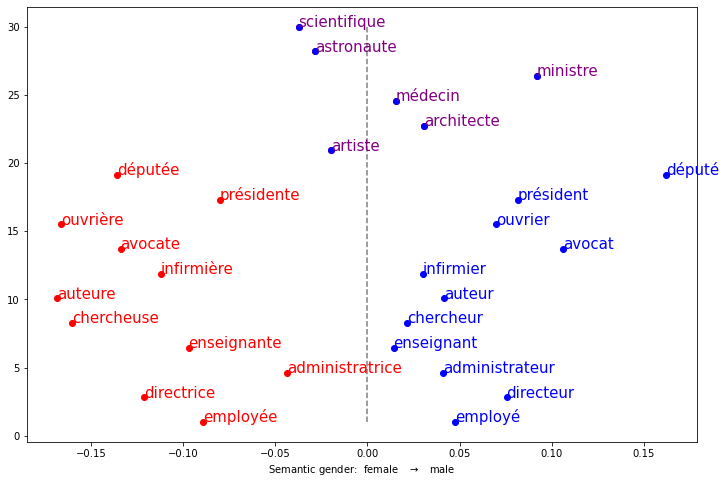

In [5]:
occupation_words = [('employée', 'employé'), 
                    ('directrice', 'directeur'), 
                    ('administratrice', 'administrateur'),
                    ('enseignante', 'enseignant'), 
                    ('chercheuse', 'chercheur'), 
                    ('auteure', 'auteur'),
                    ('infirmière', 'infirmier'), 
                    ('avocate', 'avocat'), 
                    ('ouvrière', 'ouvrier' ), 
                    ('présidente', 'président'), 
                    ('députée', 'député'), 
                    ('artiste', 'artiste'), 
                    ('architecte', 'architecte'), 
                    ('médecin', 'médecin'),
                    ('ministre', 'ministre'), 
                    ('astronaute', 'astronaute'),
                    ('scientifique', 'scientifique')]

# words with same gender form for female and male
occupation_words_same_gender = 'artiste, architecte, médecin, ministre, astronaute, scientifique'.split(', ') 

# make a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

n_occ = len(occupation_words)
y_ = np.linspace(1, 30, n_occ)
x_ = np.array([[d_pca.dot(data[female])[0], d_pca.dot(data[male])[0]] for female, male in occupation_words])

# annotation of the points
plt.scatter(x_[:, 0], y_, color='red')   # female
plt.scatter(x_[:, 1], y_, color='blue')  # male

for label, x, y in zip(np.array(occupation_words)[:, 0], x_[:, 0], y_):
  if label not in occupation_words_same_gender:
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')
  else:
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='purple')

  
for label, x, y in zip(np.array(occupation_words)[:, 1], x_[:, 1], y_):
  if label not in occupation_words_same_gender:
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')
  
plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')   # neutral vertical line

plt.xlabel(r"Semantic gender:  female   $\rightarrow$   male")
plt.show()

The pairs of occupation words are roughly well separated. We notice that male forms are much closer to 0 than female forms.

### Extracting grammatical gender direction 

To extract grammatical gender direction, we use 2 lists of grammatically feminine and masculine words. As advised in the paper by Caliskan et al., it is important to exclude animate words (i.e. alluding to people) from the lists. These can be found in:
- `data/grammatical_masculine.txt`
- `data/grammatical_feminine.txt`

These 2 lists were extracted from the Universal Dependencies french dataset. However, further pre-processing was involved to remove potential anomalies (see `code/generate_gram_gender_lists.py`).

We use LDA to learn the grammatical gender direction.

In [6]:
# loading grammatical gender word lists
with open("../data/grammatical_masculine.txt", "r") as output:
    masc_gram = output.read()
    output.close()

with open("../data/grammatical_feminine.txt", "r") as output:
    fem_gram = output.read()
    output.close()

fem_gram = fem_gram.split('\n')
masc_gram = masc_gram.split('\n')


# embeddings of grammatical gender words
X_fem, X_masc = [], []
x_list_fem, x_list_masc = [], []  # list of grammatically gendered words used in X
for fem in fem_gram:
    # some words might not have existed in the corpus of fasttext
    try:
        X_fem.append(data[fem])
        x_list_fem.append(fem)
    except:
        continue
for masc in masc_gram:
    try:
        X_masc.append(data[masc])
        x_list_masc.append(masc)
    except:
        continue

x_list_fem, x_list_masc = np.array(x_list_fem), np.array(x_list_masc)  # final lists of grammatically gender words

# prepare data for LDA
X_fem, X_masc = np.array(X_fem), np.array(X_masc)
y = np.concatenate((np.zeros(len(X_masc)), np.ones(len(X_fem))))   # 0 for masculine, 1 for feminine
X = np.concatenate((X_masc, X_fem), axis=0)

# shuffle (for safety) 
np.random.seed(42)
idx = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
X = X[idx]
y = y[idx]

# train and test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=42)

In [21]:
len(X_train)

2537

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(X_train, y_train)
print(lda.score(X_train, y_train), lda.score(X_test, y_test))

# grammatical gender direction 
d_gram = lda.scalings_/(np.linalg.norm(lda.scalings_, ord=2))
d_gram = - d_gram   # to have feminine on the left, masculine on the right

0.9873866771777691 0.9666666666666667


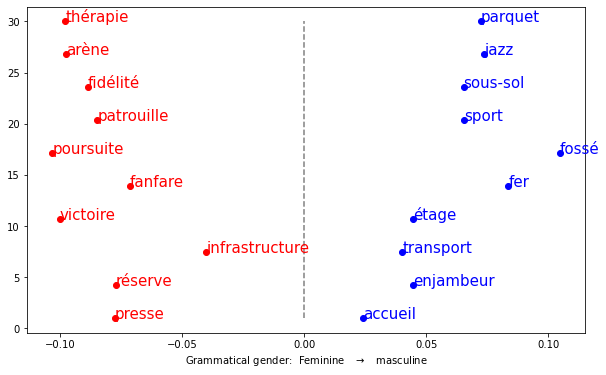

In [8]:
# randomly select some words (from the grammatical gender lists) for test
np.random.seed(42)
n_words = 10
idx_fem = np.random.choice(len(x_list_fem), size=n_words, replace=False)
idx_masc = np.random.choice(len(x_list_masc), size=n_words, replace=False)

# prepare data for the plot
y_ = np.linspace(1, 3*n_words, n_words)

x_fem = (X_fem[idx_fem]@d_gram).reshape(-1, )
x_masc= (X_masc[idx_masc]@d_gram).reshape(-1, )



# scatter plot of words
plt.figure(figsize=(10, 6))

plt.scatter(x_fem, y_, color='red')   # female
plt.scatter(x_masc, y_, color='blue')  # male

# annotation of words 
for label, x, y in zip(x_list_fem[idx_fem], x_fem, y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')

  
for label, x, y in zip(x_list_masc[idx_masc], x_masc, y_):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')
  
plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

plt.xlabel(r"Grammatical gender:  Feminine   $\rightarrow$   masculine")
plt.show()

### Orthogonalize the basis (d_gram, d_pca)

In order to orthongonalise the family of vectors (d_pca, d_gram), we use Gram-Schmidt. This is equivalent to removing the grammatical gender component from the semantic gender direction. 

$$ \tilde d_{sem} = d_{pca} - \langle d_{pca},  d_{gram}\rangle d_{gram}$$
$$ d_{sem} = \frac{\tilde d_{sem}}{\|\tilde d_{sem}\|_2}$$  

In [9]:
# removing the grammatical gender component from the semantic gender direction 
d_pca = d_pca.reshape(-1, )
d_gram = d_gram.reshape(-1, )
d_sem = d_pca - d_pca.dot(d_gram)* d_gram
d_sem = d_sem/(np.linalg.norm(d_sem, ord=2))

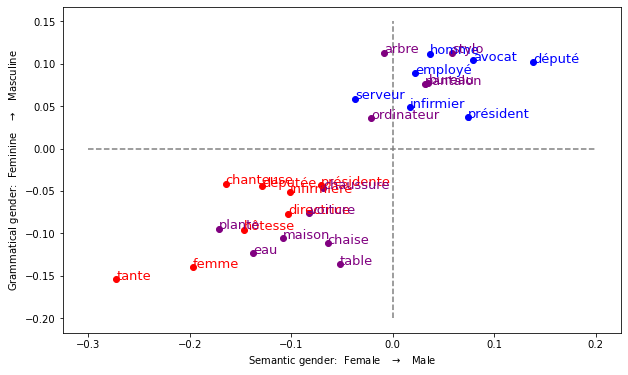

In [18]:
# test some words 
list_words_fem = 'femme, infirmière, présidente, tante, hôtesse, députée, directrice, chanteuse'.split(', ')
list_words_masc = 'homme, infirmier, président, employé, avocat, serveur, député'.split(', ')
list_words_neut = 'stylo, bureau, plante, arbre, eau, table, maison, voiture, ordinateur, chaise, pantalon, chaussure'.split(', ')
#mannequin, artiste, astronaute, médecin, architecte, scientifique, ministre

# projection of the words onto the grammatical and semantic gender directions
# female associated words 
xx_fem = np.array([d_sem @ data[word] for word in list_words_fem])   # semantic component
yy_fem = np.array([d_gram @ data[word] for word in list_words_fem])  # grammatical component

# male associated words
xx_masc = np.array([d_sem @ data[word] for word in list_words_masc])
yy_masc = np.array([d_gram @ data[word] for word in list_words_masc])

# neutral words
xx_neut = np.array([d_sem @ data[word] for word in list_words_neut])
yy_neut = np.array([d_gram @ data[word] for word in list_words_neut])


# scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(xx_fem, yy_fem, color='red')
plt.scatter(xx_masc, yy_masc, color='blue')
plt.scatter(xx_neut, yy_neut, color='purple')

# annotation 
for label, x, y in zip(list_words_fem, xx_fem, yy_fem):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=13,
                     color='red')

  
for label, x, y in zip(list_words_masc, xx_masc, yy_masc):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=13,
                     color='blue')

for label, x, y in zip(list_words_neut, xx_neut, yy_neut):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=13,
                     color='purple')
  
plt.vlines(x=0, ymin=-.2, ymax=.15, linestyles='dashed', colors='gray')    # neutral (semantic) vertical line
plt.plot(np.linspace(-.3, .2, 10), np.zeros(10), linestyle='dashed', c='gray')  # neutral (grammatical) vertical line

plt.xlabel(r"Semantic gender:  Female   $\rightarrow$   Male")
plt.ylabel(r"Grammatical gender:  Feminine   $\rightarrow$   Masculine")
plt.show()


We can see how some female occupation are closer to 0 on the semantic axis (e.g. `présidente`, `directrice`) than other occupations (e.g. `chanteuse`, `hôtesse`), which means that they have more tendency to be associated with the masculine gender. Surprisingly, `infirmière` is not far away from 0 on the semantic direction. 

In contrast, `infirmier` is closer to the neutral axis on the semantic axis compared to other male occupations. Most importantly, `serveur` even lies on the female side of the semantic axis. Same observation for `mannequin` which can be male and female.